### Generating human faces with Adversarial Networks
<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week04/images/nvidia_cool_gan.png?raw=1" width="400px"/>
© research.nvidia.com_

This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .


In [1]:
%%bash

shred -u setup_colab.py

wget https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py -O setup_colab.py

shred: setup_colab.py: failed to open for writing: No such file or directory
--2022-06-11 14:22:00--  https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1649 (1.6K) [text/plain]
Saving to: ‘setup_colab.py’

     0K .                                                     100% 25.2M=0s

2022-06-11 14:22:00 (25.2 MB/s) - ‘setup_colab.py’ saved [1649/1649]



In [2]:
import setup_colab

setup_colab.setup_week04()

In [3]:
import download_utils

download_utils.download_week_4_resources('.')

**************************************************
lfw-deepfunneled.tgz
**************************************************
lfw.tgz
**************************************************
lfw_attributes.txt


In [4]:
import grading

grader = grading.Grader(
    assignment_key="FCl7G51lEeeeZQ4xJ2nzLA",
    all_parts=["ryO01"]
)

In [25]:
# token expires every 30 min
COURSERA_TOKEN = "x7dDLhVCHCDvyWWO"
COURSERA_EMAIL = "susanmalkin@gmail.com"

In [6]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

In [7]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
# The following line fetches you two datasets:
# images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles),
# so please keep them in mind
from lfw_dataset import load_lfw_dataset 
data, attrs = load_lfw_dataset(dimx=36, dimy=36)

# preprocess faces
data = np.float32(data) / 255.

data = torch.from_numpy(data).permute(0, 3, 1, 2)

min_data = data.min()
max_data = data.max()

IMG_SHAPE = data.shape[1:]

In [8]:
print(IMG_SHAPE)

torch.Size([3, 36, 36])


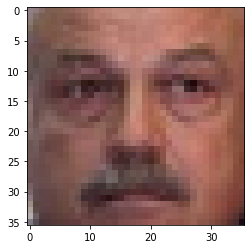

In [9]:
# print random image
plt.imshow(data[np.random.randint(data.shape[0])].permute(1, 2, 0),
           cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week04/images/noise_to_face.png?raw=1" width="400px"/>
_© torch.github.io_

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 1.11.0+cu113
Using GPU


In [11]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    
    def __init__(self, shape):
        super().__init__()
        
        self.shape = shape
        
    def forward(self, input):
        return input.view(self.shape)

In [12]:
CODE_SIZE = 256

from itertools import count
# automatic layer name maker. Don't do this in production :)
ix = ('layer_%i'%i for i in count())

def make_generator():
    generator = nn.Sequential()

    generator.add_module(next(ix), nn.Linear(CODE_SIZE, 10 * 8 *8))
    generator.add_module(next(ix), nn.ELU())
    generator.add_module(next(ix), Reshape([-1, 10, 8, 8]))

    generator.add_module(next(ix), nn.ConvTranspose2d(10, 64, kernel_size=(5, 5)))
    generator.add_module(next(ix), nn.ELU())
    generator.add_module(next(ix), nn.ConvTranspose2d(64, 64, kernel_size=(5, 5)))
    generator.add_module(next(ix), nn.ELU())
    generator.add_module(next(ix), nn.Upsample(scale_factor=2))

    generator.add_module(next(ix), nn.ConvTranspose2d(64, 32, kernel_size=(5, 5)))
    generator.add_module(next(ix), nn.ELU())
    generator.add_module(next(ix), nn.ConvTranspose2d(32, 32, kernel_size=(5, 5)))
    generator.add_module(next(ix), nn.ELU())

    generator.add_module(next(ix), nn.Conv2d(32, 3, kernel_size=(5, 5)))

    return generator

generator = make_generator()

if use_cuda:
    generator = generator.cuda()

In [13]:
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, \
    "generator must output an image of shape %s, but instead it produces %s" % (IMG_SHAPE, generated_data.shape)

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [14]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    batch = torch.tensor(data[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

In [15]:
# Create convolutional architecture for discriminator
# Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

# YOUR CODE HERE
class Discriminator(nn.Module):
    
    # note that typing is not necessary
    # but it makes life much easier
    def __init__(self):
        super().__init__()
        
        ### YOUR CODE HERE ###
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.ELU(),
            nn.MaxPool2d(2, stride=2),
            nn.AdaptiveAvgPool2d((16,16)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ELU(),
            nn.Conv2d(64, 10, 5),
            nn.Flatten(start_dim=1),
            nn.Linear(10*8*8, 256),
            nn.ELU(),
            nn.Linear(256, 1),
            )
   
    def forward(self, image: torch.Tensor):
        return self.discriminator(image)
    

discriminator = Discriminator()

ans = len(discriminator(torch.rand(1, *IMG_SHAPE)))

if use_cuda: 
    discriminator = discriminator.cuda()

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week04/images/gan.png?raw=1" width="600px"/>
_© deeplearning4j.org_

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [16]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    # YOUR CODE HERE

    generated_data = generator(noise)
    
    disc_on_generated_data = discriminator(generated_data)
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    
    loss = -1 * torch.mean(logp_gen_is_real)
    
    return loss.reshape((1))


In [17]:
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

tensor([0.7104], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)


In [18]:
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    
    # YOUR CODE HERE
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(1 - disc_on_fake_data)
    
    loss = -1 * torch.mean(logp_real_is_real + logp_gen_is_fake)
    return loss.reshape(1)



In [19]:
loss = discriminator_loss(
    sample_data_batch(32),
    generator(sample_noise_batch(32))
)

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

tensor([1.0092], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [20]:
def sample_images(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow * ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    
    if np.var(images) != 0:
        images = images.clip(min_data, max_data)
        
    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = F.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = F.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0, 1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0, 1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and plot results once every N iterations.

In [21]:
#optimizers
discriminator = Discriminator()
generator = make_generator()

if use_cuda:
    discriminator = discriminator.cuda()
    generator = generator.cuda()

disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

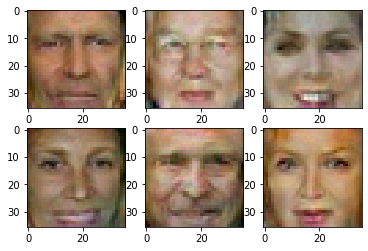

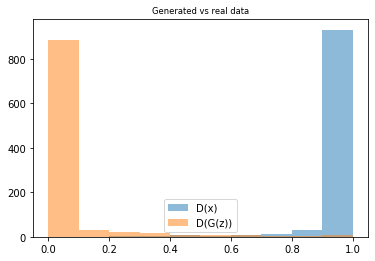

In [22]:
from IPython import display
from tqdm import tnrange
batch_size = 100

for epoch in tnrange(20000):
    
    # Train discriminator
    for i in range(5):
        real_data = sample_data_batch(batch_size)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()
        
    # Train generator
    noise = sample_noise_batch(batch_size)
    loss = generator_loss(noise)
    gen_opt.zero_grad()
    loss.backward()
    gen_opt.step()
    
    if epoch % 100 == 0:
        display.clear_output(wait=True)
        sample_images(2, 3, True)
        sample_probas(1000)

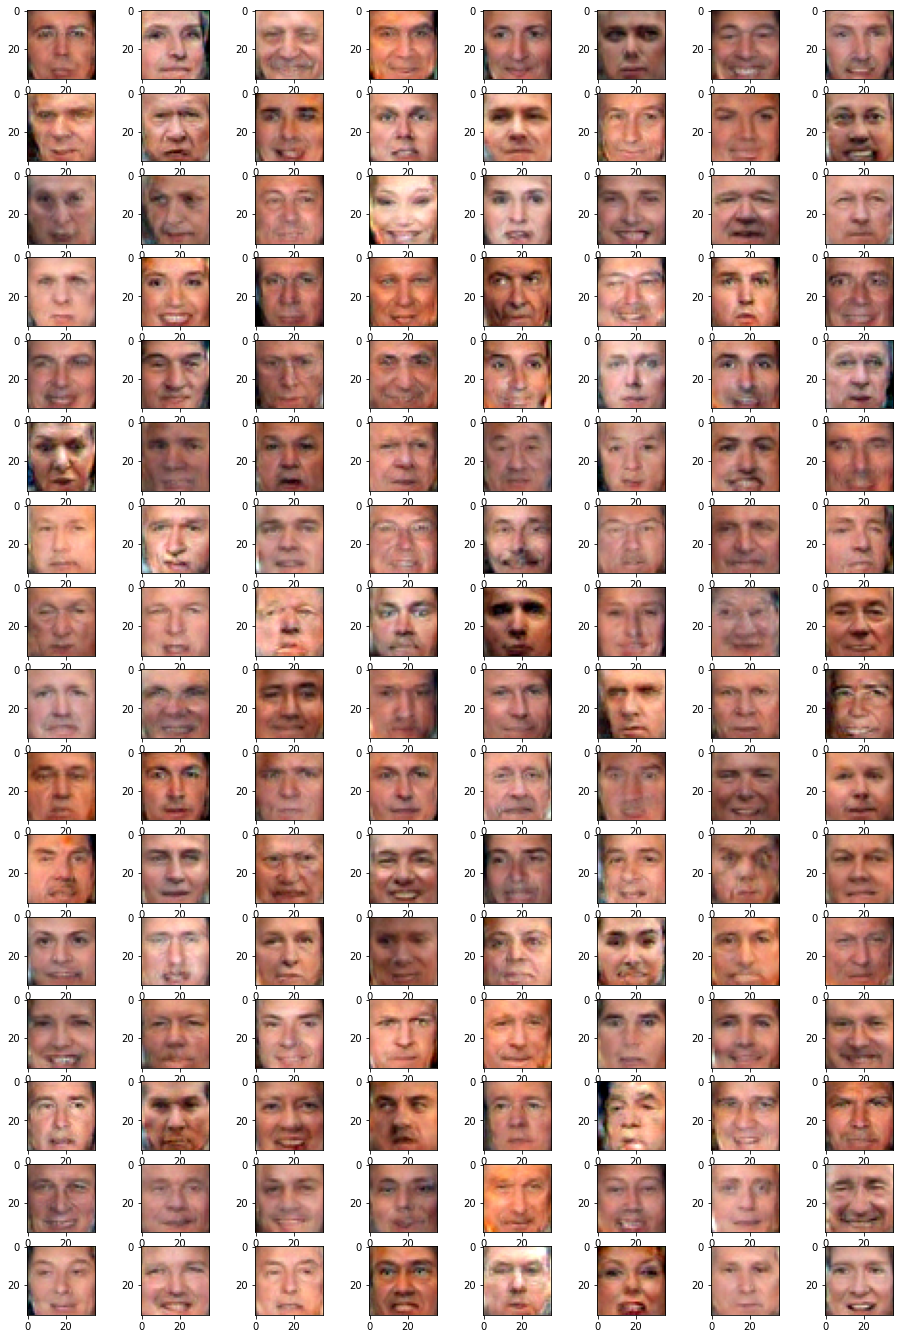

In [23]:
#The network was trained for about 15k iterations.
#Training for longer yields MUCH better results
plt.figure(figsize=[16, 24])
sample_images(16, 8)

# Submit to Coursera

In [24]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("ryO01", ans)

In [26]:
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
